In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # Overfitting and Regularization

In the realm of predictive modeling, the pursuit of creating a model that perfectly fits the training data can inadvertently lead to a phenomenon known as overfitting. Overfitting occurs when a model becomes excessively complex, capturing not only the genuine patterns within the data but also the noise and random fluctuations present in the training set. 

The hyper-adaptation to the training data renders the model less capable of generalizing to new, unseen data, as it effectively memorizes the training examples rather than discerning meaningful relationships. As a result, an overfitted model may exhibit impressive performance on the training data but performs poorly when faced with real-world scenarios. The delicate balance between capturing essential patterns and avoiding the trap of overfitting underscores the importance of techniques like regularization, which aim to ensure model generalization by restraining excessive complexity.

There are three Regularization techniques we will be dealing with, all of which use the idea of penalizing terms to tackle overfitting.

But before we go any further, let's have a look at the data.

**Data Dictionary**

* Product_ID:- Unique identifier for each electronic device. <br>
* Product_Weight:- Weight of the device  <br>
* Energy_Efficiency:- Energy efficiency rating (e.g., "Energy Efficient", "Standard"). <br>
* Visibility_Index:- The % of the total display area of all products in a store allocated to the particular product <br>
* Product_Category:- Category of the electronic device (e.g., "Laptops", "Smartphones"). <br>
* Product_Price:- Price of the device in dollars<br>
* Store_ID:- Unique identifier for the store.<br>
* Store_Established_Year:- Number of years since the store was established.<br>
* Store_Size:- Size classification of the store (e.g., "Small", "Medium").<br>
* Location_Type:- The type of city in which the store is located<br>
* Store_Type:- Type of store (e.g., "Electronics Store Type1").<br>
* Sales_Performance:- Sales of the electronic device in the particular store. This is the outcome variable to be predicted.


## Visualizing the data

Let's visualize this all in the form of a Data Frame

In [ ]:
data <- read.csv("/kaggle/input/2b-data/2b-data.csv")
head(data)


## Ridge Regression
Ridge regression is a linear regression technique that incorporates L2 regularization to address issues in predictive modeling (overfitting, multi-colinearity etc).
Linear regression, aims to minimize the sum of squared residuals whereas Ridge regression introduces a penalty term proportional to the square of the magnitude of the coefficients. This penalty, controlled by a hyperparameter (often denoted as lambda), discourages large coefficient values, effectively constraining the model’s complexity, enhancing its stability and generalization performance.


**1)** Perform Ridge Regression on the training data and compare the predictions with the test data to check for the fit of the model. (Hint: Use the glmnet library) (2 marks) <br>
You can split the dataset into 70% train and 30% test.  

[1] "Best lambda: 95.8895125587801"
[1] "RMSE: 1132.32269000549"
33 x 1 sparse Matrix of class "dgCMatrix"
                                                      s0
(Intercept)                                  -20.2233503
Product_Weight                                 0.6742916
Energy_Efficiency.Energy.Efficient           -24.1965256
Energy_Efficiency.Standard                    23.0647323
Visibility_Index                            -306.7925573
Product_Category.Air.Conditioners            -28.4366751
Product_Category.Cameras                     -22.7947713
Product_Category.Headphones                    8.5276798
Product_Category.Home.Theater.Systems        310.0697565
Product_Category.Keyboards                    69.2369572
Product_Category.Laptops                      -3.9533090
Product_Category.Microwaves                    8.3327265
Product_Category.Miscellaneous.Electronics   -26.9141650
Product_Category.Monitors                     15.6481233
Product_Category.Mouse                

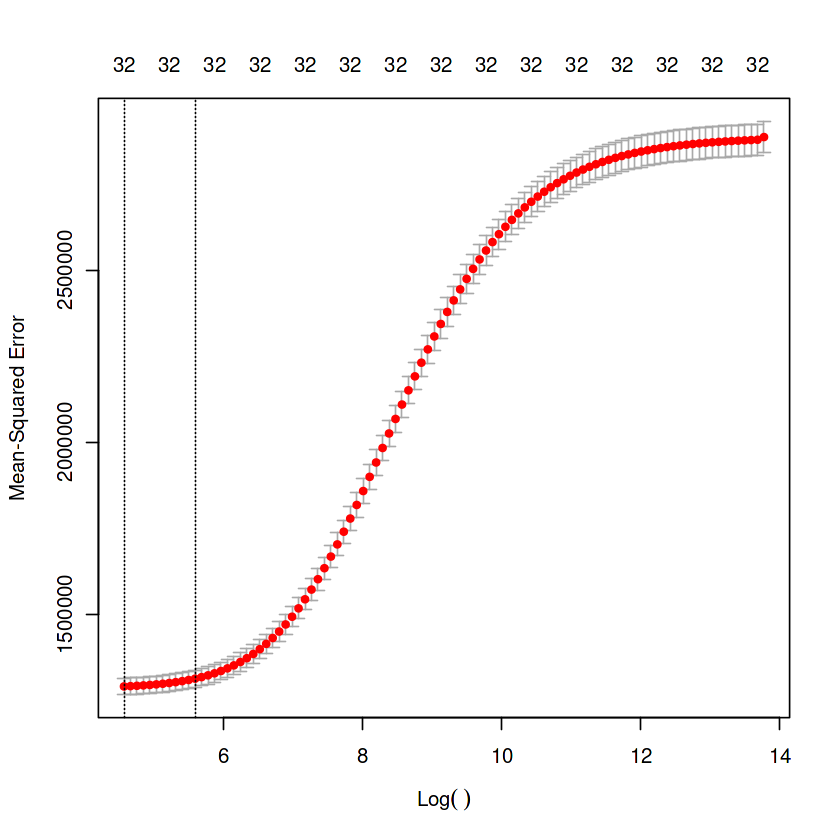

In [3]:
library(glmnet)
library(caret)

# Data preprocessing
data$Energy_Efficiency <- as.factor(data$Energy_Efficiency)
data$Product_Category <- as.factor(data$Product_Category)
data$Store_Size <- as.factor(data$Store_Size)
data$Location_Type <- as.factor(data$Location_Type)
data$Store_Type <- as.factor(data$Store_Type)

# Create dummy variables
dummy <- dummyVars(" ~ .", data = data[, -c(1, 7)]) # Exclude Product_ID and Store_ID
data_encoded <- data.frame(predict(dummy, newdata = data[, -c(1, 7)]))

# Add Sales_Performance back to the encoded data
data_encoded$Sales_Performance <- data$Sales_Performance

# Split the data
set.seed(123)
train_index <- createDataPartition(data_encoded$Sales_Performance, p = 0.7, list = FALSE)
train_data <- data_encoded[train_index, ]
test_data <- data_encoded[-train_index, ]

# Prepare matrices for glmnet
x_train <- as.matrix(train_data[, !colnames(train_data) %in% c("Sales_Performance")])
y_train <- train_data$Sales_Performance
x_test <- as.matrix(test_data[, !colnames(test_data) %in% c("Sales_Performance")])
y_test <- test_data$Sales_Performance

# Perform cross-validation to find the best lambda
cv_ridge <- cv.glmnet(x_train, y_train, alpha = 0)

# Print the best lambda
print(paste("Best lambda:", cv_ridge$lambda.min))

# Fit Ridge model with optimal lambda
optimal_ridge <- glmnet(x_train, y_train, alpha = 0, lambda = cv_ridge$lambda.min)

# Make predictions
predictions <- predict(optimal_ridge, newx = x_test)

# Calculate RMSE
rmse <- sqrt(mean((y_test - predictions)^2))
print(paste("RMSE:", rmse))

# Print coefficients
coef_ridge <- coef(optimal_ridge)
print(coef_ridge)

# Plot the cross-validation curve
plot(cv_ridge)

**2)** Is it possible for you to somehow conduct hyperparameter tuning and find the best lambda value for the Ridge Regression model? (Hint: use the cv.glmnet function)   (1 mark)

**3)** With the optimal lambda, build the model again and print the coefficients of the various dependent variables. What can you comment about the relationship between lambda and the strength of regularization?        (2 marks)


## Lasso Regression

Lasso regression is similar to Ridge Regression except that instead of L2 regularization, it employs L1 regularization to address the very same issues that Ridge Regression addresses. 

There are however, a couple of differences between the two. The first and most obvious being that since Lasso Regression implements L1 regularization, the penalty term in this case is proportional to the absolute value of the coefficient. 

Another point to note is that unlike its Ridge counterpart, Lasso Regression can push some coefficients to exactly 0. This effectively drops the feature from the predictive model (Similar to how we drop values through visual analysis). Lasso Regression can thus be used effectively for Feature Selection as well.

**1)** Write code to build a Lasso Regression model similar to how you built the Ridge Regression model. This time incorporate hyperparameter tuning right away. So first print the optimal lambda value.                  (2 marks)

**2)** Display the coefficients of all the variables. Do you notice some variables being dropped out? Which ones are they?   (1 mark)

In [4]:
# Perform cross-validation to find the best lambda for Lasso
cv_lasso <- cv.glmnet(x_train, y_train, alpha = 1)

# Print the best lambda
print(paste("Best lambda for Lasso:", cv_lasso$lambda.min))

# Fit Lasso model with optimal lambda
optimal_lasso <- glmnet(x_train, y_train, alpha = 1, lambda = cv_lasso$lambda.min)

# Make predictions
lasso_predictions <- predict(optimal_lasso, newx = x_test)

# Calculate RMSE
lasso_rmse <- sqrt(mean((y_test - lasso_predictions)^2))
print(paste("Lasso RMSE:", lasso_rmse))

# Print coefficients
lasso_coef <- coef(optimal_lasso)
print(lasso_coef)

# Identify dropped variables
dropped_vars <- rownames(lasso_coef)[which(lasso_coef == 0)]
print("Dropped variables:")
print(dropped_vars)

[1] "Best lambda for Lasso: 14.5743532877044"
[1] "Lasso RMSE: 1127.72824714709"
33 x 1 sparse Matrix of class "dgCMatrix"
                                                      s0
(Intercept)                                 1.868906e+02
Product_Weight                              .           
Energy_Efficiency.Energy.Efficient         -2.741504e+01
Energy_Efficiency.Standard                  5.251944e-11
Visibility_Index                            .           
Product_Category.Air.Conditioners           .           
Product_Category.Cameras                    .           
Product_Category.Headphones                 .           
Product_Category.Home.Theater.Systems       1.394868e+02
Product_Category.Keyboards                  .           
Product_Category.Laptops                    .           
Product_Category.Microwaves                 .           
Product_Category.Miscellaneous.Electronics  .           
Product_Category.Monitors                   .           
Product_Category.Mouse

## Elastic Net Regression

Elastic Net regression, an advanced form of linear regression, combines the benefits of L1 (Lasso) and L2 (Ridge) regularization methods. By integrating both penalty terms, Elastic Net overcomes the limitations of each, offering resilience against multicollinearity, aiding feature selection, and preventing overfitting. 

This approach makes Elastic Net a very versatile approach for achieving accurate and efficient models by finding a middle ground between dropping parameters and retaining important predictors. 

**1)** Build your Elastic Net Regression model incorporating all the steps we previously followed for ridge and lasso regression. (Play around with the alpha value and find out how it affects the model)            (2 marks)


In [5]:
## Write your code here
# Function to perform Elastic Net with a given alpha
elastic_net <- function(alpha) {
  cv_elastic <- cv.glmnet(x_train, y_train, alpha = alpha)
  optimal_elastic <- glmnet(x_train, y_train, alpha = alpha, lambda = cv_elastic$lambda.min)
  predictions <- predict(optimal_elastic, newx = x_test)
  rmse <- sqrt(mean((y_test - predictions)^2))
  return(list(model = optimal_elastic, rmse = rmse))
}

# Try different alpha values
alphas <- c(0.2, 0.4, 0.6, 0.8)
results <- lapply(alphas, elastic_net)

# Print results
for (i in seq_along(alphas)) {
  print(paste("Alpha:", alphas[i], "RMSE:", results[[i]]$rmse))
}

# Choose the best alpha (you can modify this based on your preference)
best_alpha <- alphas[which.min(sapply(results, function(x) x$rmse))]
best_model <- results[[which.min(sapply(results, function(x) x$rmse))]]$model

print(paste("Best alpha:", best_alpha))

# Print coefficients of the best model
elastic_coef <- coef(best_model)
print(elastic_coef)

# Identify dropped variables
elastic_dropped_vars <- rownames(elastic_coef)[which(elastic_coef == 0)]
print("Dropped variables in Elastic Net:")
print(elastic_dropped_vars)

[1] "Alpha: 0.2 RMSE: 1128.93013194789"
[1] "Alpha: 0.4 RMSE: 1128.40221856218"
[1] "Alpha: 0.6 RMSE: 1128.01408133359"
[1] "Alpha: 0.8 RMSE: 1128.36755879098"
[1] "Best alpha: 0.6"
33 x 1 sparse Matrix of class "dgCMatrix"
                                                     s0
(Intercept)                                  189.450516
Product_Weight                                 .       
Energy_Efficiency.Energy.Efficient           -24.563304
Energy_Efficiency.Standard                     5.440435
Visibility_Index                               .       
Product_Category.Air.Conditioners              .       
Product_Category.Cameras                       .       
Product_Category.Headphones                    .       
Product_Category.Home.Theater.Systems        155.351305
Product_Category.Keyboards                     .       
Product_Category.Laptops                       .       
Product_Category.Microwaves                    .       
Product_Category.Miscellaneous.Electronics     .

Identify and list the variables that have been dropped in the Elastic Net model. How does this compare to the variables dropped in the Lasso model? <br>
What does that tell you about the number of hyperparameters in Elastic Net Regression compared to the other two models?